In [4]:
import sys
import os
import numpy as np
import xarray as xr
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.gridspec import GridSpec
from pathlib import Path

sys.path.append(os.path.expanduser('~/Documents/Hybrid/'))
from Hybrid.neuralnet import DEFAULT_FIT
from Hybrid.dataprep import default_prep
from Hybrid.interpretation import combine_input_output, composite_extremes, model_to_submodel, order_by_hierachical_clustering, gradient, kernel_shap

In [5]:
focus_class = -1 # Index of the class to be scored
name = 'tg-anom_JJA_45r1_31D-roll-mean_q0.5_sep12-15'
#name = 'tg-ex-q0.75-21D_ge7D_sep12-15'
prepared_data, constructor = default_prep(predictandname=name, npreds = 4, use_jmeasure=False, focus_class = focus_class)

fitting a new feature scaler
using a pre-fitted feature scaler


In [6]:
# Training the model and generating predictions
model = constructor.fresh_model()
model.fit(x = prepared_data.neural.trainval_inputs, y=prepared_data.neural.trainval_output, validation_split = 0.33, **DEFAULT_FIT)
preds_test = model.predict(x = prepared_data.neural.test_inputs)
preds_trainval = model.predict(x = prepared_data.neural.trainval_inputs)

2022-01-05 16:12:16.104113: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-05 16:12:16.115775: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3591565000 Hz


Epoch 1/200
41/41 [==============================] - 0s 4ms/step - loss: 0.7254 - accuracy: 0.5498 - brier: 0.2594 - val_loss: 0.7852 - val_accuracy: 0.4826 - val_brier: 0.2888
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.7211 - accuracy: 0.5498 - brier: 0.2573 - val_loss: 0.7816 - val_accuracy: 0.4826 - val_brier: 0.2874
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.7153 - accuracy: 0.5832 - brier: 0.2545 - val_loss: 0.7772 - val_accuracy: 0.4905 - val_brier: 0.2856
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.7064 - accuracy: 0.5956 - brier: 0.2504 - val_loss: 0.7716 - val_accuracy: 0.4874 - val_brier: 0.2833
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6952 - accuracy: 0.5933 - brier: 0.2454 - val_loss: 0.7645 - val_accuracy: 0.4984 - val_brier: 0.2803
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6810 - accuracy: 0.6026 - brier: 0.2387 

41/41 [==============================] - 0s 1ms/step - loss: 0.5316 - accuracy: 0.7605 - brier: 0.1698 - val_loss: 0.6198 - val_accuracy: 0.6356 - val_brier: 0.2173
Epoch 48/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5311 - accuracy: 0.7644 - brier: 0.1694 - val_loss: 0.6184 - val_accuracy: 0.6388 - val_brier: 0.2169
Epoch 49/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5326 - accuracy: 0.7535 - brier: 0.1701 - val_loss: 0.6195 - val_accuracy: 0.6372 - val_brier: 0.2172
Epoch 50/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5318 - accuracy: 0.7613 - brier: 0.1698 - val_loss: 0.6191 - val_accuracy: 0.6388 - val_brier: 0.2171
Epoch 51/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5311 - accuracy: 0.7605 - brier: 0.1695 - val_loss: 0.6208 - val_accuracy: 0.6356 - val_brier: 0.2176
Epoch 52/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5309 - accuracy: 0.7621 - brier: 0.1692 - val_l

In [31]:
# Gathering outputs
outpos = combine_input_output(model = model, feature_inputs = np.concatenate([prepared_data.neural.trainval_inputs[0],prepared_data.neural.test_inputs[0]]), 
                              log_of_raw = np.concatenate([prepared_data.neural.trainval_inputs[-1],prepared_data.neural.test_inputs[-1]]), target_class_index = -1, 
                              feature_names = prepared_data.raw.predictors.columns.to_flat_index(), index = prepared_data.crossval.X_trainval.index.append(prepared_data.crossval.X_test.index))
outneg = combine_input_output(model = model, feature_inputs = np.concatenate([prepared_data.neural.trainval_inputs[0],prepared_data.neural.test_inputs[0]]), 
                              log_of_raw = np.concatenate([prepared_data.neural.trainval_inputs[-1],prepared_data.neural.test_inputs[-1]]), target_class_index = 0, 
                              feature_names = prepared_data.raw.predictors.columns.to_flat_index(), index = prepared_data.crossval.X_trainval.index.append(prepared_data.crossval.X_test.index))
outpos['change'] = outpos['f_cor'] - outpos['f_raw']
outneg['change'] = outneg['f_cor'] - outneg['f_raw']
outpos['perc_change'] = (outpos['f_cor'] - outpos['f_raw']) / outpos['f_raw'] * 100
outneg['perc_change'] = (outneg['f_cor'] - outneg['f_raw']) / outneg['f_raw'] * 100

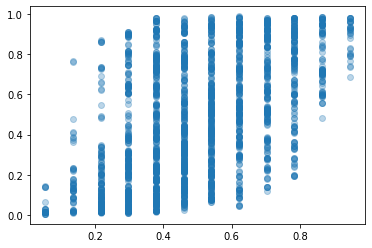

In [9]:
plt.scatter(outpos['f_raw'], outpos['f_cor'], alpha = 0.3) # The amount of change is less at the tails (already certain)

* Changes to f_raw are least present at the extremes (1,0). Inbetween a lot is possible.

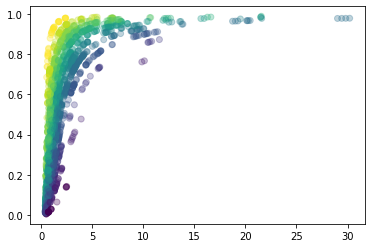

In [10]:
plt.scatter(outpos['multi'], outpos['f_cor'], c = outpos['f_raw'], alpha = 0.3) # Lines come from the raw (discrete) forecast values.

* Large multiplications (e.g. > 3) are usually also associated to larger corrected probabilities. However, not neccesarily the case when one starts with a low f_raw.

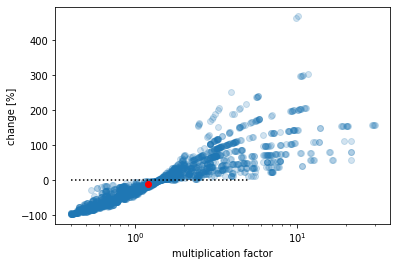

In [29]:
plt.scatter(outpos['multi'], outpos['perc_change'], alpha = 0.2)
plt.plot([0.4,5],[0,0], ls = ':', color = 'black')
plt.scatter(outpos['multi'].median(), outpos['perc_change'].median(), color = 'red')
plt.xscale('log')
plt.xlabel('multiplication factor')
plt.ylabel('change [%]')
plt.show()

* Especially multiplications below 1 lead to a reduction that is larger (probably because the negative class is scaled up heavily). The general pattern for this target is also an overall decrease of the positive class because it is overforecast.
* Same curve is present for the negative class (because of course there is a limit to multiplications >1.)

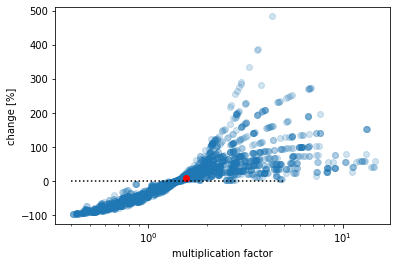

In [32]:
plt.scatter(outneg['multi'], outneg['perc_change'], alpha = 0.2)
plt.plot([0.4,5],[0,0], ls = ':', color = 'black')
plt.scatter(outneg['multi'].median(), outneg['perc_change'].median(), color = 'red')
plt.xscale('log')
plt.xlabel('multiplication factor')
plt.ylabel('change [%]')
plt.show()

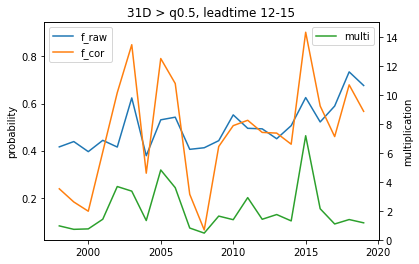

In [33]:
seasonal_mean = outpos[['f_raw','multi','f_cor']].groupby(outpos.index.get_level_values('time').year).mean()
fig, ax1 = plt.subplots()
ax1.plot(seasonal_mean[['f_raw','f_cor']], label = ['f_raw','f_cor'])
ax1.set_ylabel('probability')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(seasonal_mean['multi'], label = 'multi', color = 'tab:green')
ax2.set_ylim(0,15)
ax2.set_ylabel('multiplication')
ax2.legend()
ax1.set_title('31D > q0.5, leadtime 12-15')
plt.show()

In [31]:
# Correlation matrices. Which predictors correlate best with the corrections?
# Perhaps linear correlation is not the best, as we have a non-linear method.
from scipy.stats import spearmanr

In [32]:
pearson = np.corrcoef(outpos.values.T)
spearman = spearmanr(outpos.values, axis = 0)[0]
with_multi = pd.DataFrame({'pearson':pearson[1,:],'spearman':spearman[1,:]}, index = outpos.columns)
with_raw = pd.DataFrame({'pearson':pearson[0,:],'spearman':spearman[0,:]}, index = outpos.columns)
#plt.imshow(cormat)

In [33]:
pearson = np.corrcoef(outneg.values.T)
spearman = spearmanr(outneg.values, axis = 0)[0]
with_multi_neg = pd.DataFrame({'pearson':pearson[1,:],'spearman':spearman[1,:]}, index = outneg.columns)
with_raw_neg = pd.DataFrame({'pearson':pearson[0,:],'spearman':spearman[0,:]}, index = outneg.columns)

In [34]:
pd.concat([with_multi,with_multi_neg], axis = 1, keys = ['pos','neg'])

pos                 neg          
                                  pearson  spearman   pearson  spearman
f_raw                           -0.034737  0.026993  0.075839  0.020719
multi                            1.000000  1.000000  1.000000  1.000000
f_cor                            0.596540  0.847647  0.640901  0.843685
(sst_nhplus, 21, 4, spatcov)     0.448440  0.667724 -0.597258 -0.656219
(sst, 21, 3, mean)              -0.273448 -0.150633  0.156214  0.162676
(t850_nhblock, 21, 0, mean)      0.337232  0.351268 -0.306059 -0.343066
(swvl13_europe, 11, 0, spatcov) -0.278256 -0.344322  0.262106  0.360383
realchange                       0.688208  0.972381  0.581913  0.936959

In [35]:
pd.concat([with_multi,with_raw], axis = 1, keys = ['multi','raw']).loc[:,(slice(None),'spearman')]

,multi,raw
,spearman,spearman
f_raw,0.026993,1.000000
multi,1.000000,0.026993
f_cor,0.847647,0.506184
"(sst_nhplus, 21, 4, spatcov)",0.667724,0.224952
"(sst, 21, 3, mean)",-0.150633,0.333485
"(t850_nhblock, 21, 0, mean)",0.351268,0.093067
"(swvl13_europe, 11, 0, spatcov)",-0.344322,0.111409
realchange,0.972381,0.026627


* So it is interesting that there are variables with a different relation to the correction than the the raw forecast probability. This means that they are not just used for negative moderation (lowering when values are high, heightening when values are low). SSt and swvl13 are such examples.
* It can also be concluded that the variables actually have weak links to the raw forecast probabilities (and presumably also to the observation).
* The fact that the first strong factor is really related to the multi and less (but still positive) to the raw values, might indicate that this is an underexpressed link.

In [38]:
# Composites for extreme corrections.

In [39]:
composite_extremes(outpos,level = 0.1)

,0.1,neutral,0.9
f_raw,0.449858,0.506519,0.491821
multi,0.464194,1.546279,9.067288
f_cor,0.077814,0.474271,0.918585
"(sst_nhplus, 21, 4, spatcov)",0.223533,0.477371,0.655079
"(sst, 21, 3, mean)",0.417695,0.421577,0.255931
"(t850_nhblock, 21, 0, mean)",0.346093,0.457184,0.575217
"(swvl13_europe, 11, 0, spatcov)",0.666638,0.546049,0.420815
realchange,0.150141,0.950989,2.094103


In [40]:
composite_extremes(outpos, columnname = 'f_raw', level = 0.1)

,0.1,neutral,0.9
f_raw,0.177731,0.510644,0.886443
multi,1.712755,2.290917,1.498322
f_cor,0.183649,0.491418,0.803839
"(sst_nhplus, 21, 4, spatcov)",0.409245,0.470057,0.570515
"(sst, 21, 3, mean)",0.330681,0.402452,0.566748
"(t850_nhblock, 21, 0, mean)",0.411863,0.461074,0.488683
"(swvl13_europe, 11, 0, spatcov)",0.545610,0.539634,0.638182
realchange,1.033436,0.985011,0.906221


* The changing scales, sometimes opposite signs make me think about the association direction in scatterplots. A factor usually associated with higher probabilities, need not be in the same way be associated to overforcasting.
* plus isn't it possible to show the bivariate plot (combination of empirical factors leading to higher) for raw probabilities, and to show the same for with heightened corrected probabilities?

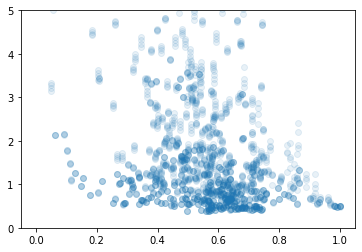

In [46]:
fig, ax = plt.subplots()
ax.scatter(outpos[('swvl13_europe', 11, 0, 'spatcov')], outpos['multi'], alpha = 0.1)
ax.set_ylim(0,5)
plt.show()

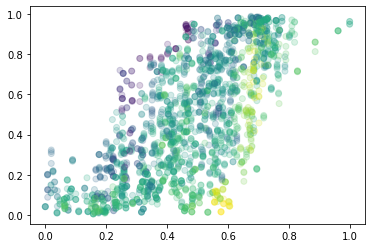

In [50]:
plt.scatter(outpos[('sst_nhplus', 21, 4, 'spatcov')], outpos['f_cor'], alpha = 0.2, c = outpos[('swvl13_europe', 11, 0, 'spatcov')])

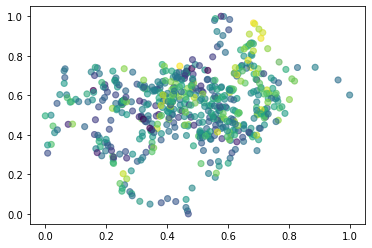

In [48]:
plt.scatter(outpos[('sst_nhplus', 21, 4, 'spatcov')],outpos[('swvl13_europe', 11, 0, 'spatcov')], alpha = 0.2, c = outpos[('f_raw')])

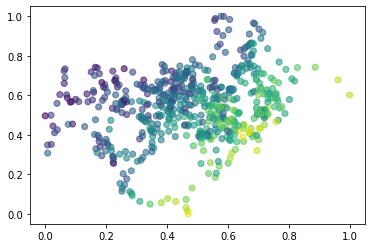

In [72]:
plt.scatter(outpos[('sst_nhplus', 21, 4, 'spatcov')],outpos[('swvl13_europe', 11, 0, 'spatcov')], alpha = 0.2, c = outpos[('realchange')])

### Explanation of situations.
I.e. a grouping of the XAI explanations.

In [39]:
inpgrad_full = gradient(model=model, feature_inputs = np.concatenate([features_trainval,features_test]), additional_inputs = np.concatenate([logforc_trainval,logforc_test]), times_input = True)
inpgrad_full = pd.DataFrame(inpgrad_full, index = X_trainval.index.append(X_test.index), columns = X_trainval.columns)
inpgrad_full = order_by_hierachical_clustering(inpgrad_full)

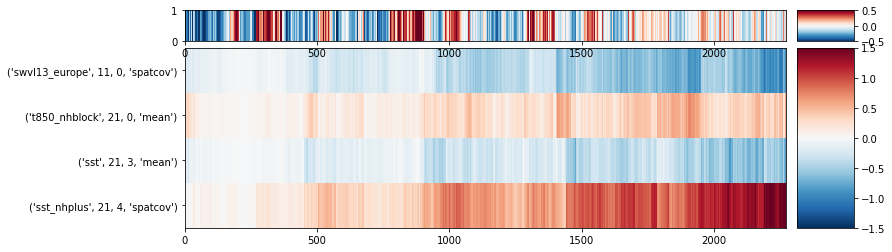

In [66]:
fig = plt.figure(figsize=(12,4), facecolor = 'white')
gs1 = GridSpec(nrows = 6, ncols = 10, hspace=0.2)
ax_expl = fig.add_subplot(gs1[1:, :-1])
ax_cor = fig.add_subplot(gs1[:1, :-1])
ax_cbar_expl = fig.add_subplot(gs1[1:, -1:])
ax_cbar_cor = fig.add_subplot(gs1[:1, -1:])

expl = ax_expl.pcolor(inpgrad_full.T.values, vmin = -1.5, vmax = 1.5, cmap = 'RdBu_r')
ax_expl.set_yticks(np.arange(0.5, len(inpgrad_full.columns)+0.5, 1))
ax_expl.set_yticklabels(inpgrad_full.columns.to_flat_index().values)
cor = ax_cor.pcolor(outpos[['realchange']].reindex(inpgrad_full.index).T.values, vmin = -0.5, vmax = 0.5, cmap = 'RdBu_r')
fig.colorbar(expl, cax = ax_cbar_expl)
fig.colorbar(cor, cax = ax_cbar_cor)

This exists of explanations of the final outcome. So probably we get relation to the heat in general too, which might explain big corrections at very neutral explanation values. Perhaps submodel input times gradient is more informative.

In [56]:
inpgrad_sub = gradient(model=model_to_submodel(model, exp_of_log_of_multiplier=True), feature_inputs = np.concatenate([features_trainval,features_test]), times_input = True)
inpgrad_sub = pd.DataFrame(inpgrad_sub, index = X_trainval.index.append(X_test.index), columns = X_trainval.columns)
inpgrad_sub = order_by_hierachical_clustering(inpgrad_sub)

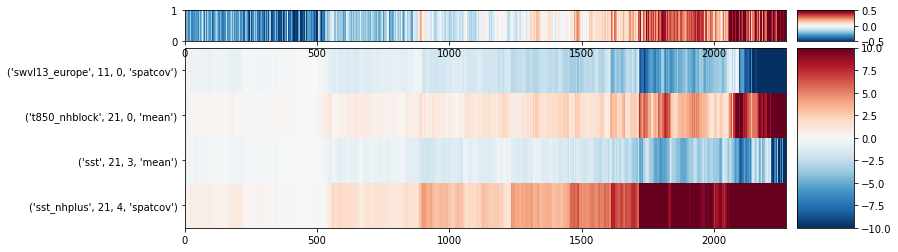

In [65]:
fig = plt.figure(figsize=(12,4), facecolor = 'white')
gs1 = GridSpec(nrows = 6, ncols = 10, hspace=0.2)
ax_expl = fig.add_subplot(gs1[1:, :-1])
ax_cor = fig.add_subplot(gs1[:1, :-1])
ax_cbar_expl = fig.add_subplot(gs1[1:, -1:])
ax_cbar_cor = fig.add_subplot(gs1[:1, -1:])

expl = ax_expl.pcolor(inpgrad_sub.T.values, vmin = -10, vmax = 10, cmap = 'RdBu_r')
ax_expl.set_yticks(np.arange(0.5, len(inpgrad_sub.columns)+0.5,1))
ax_expl.set_yticklabels(inpgrad_sub.columns.to_flat_index().values)
cor = ax_cor.pcolor(outpos[['realchange']].reindex(inpgrad_sub.index).T.values, vmin = -0.5, vmax = 0.5, cmap = 'RdBu_r')
fig.colorbar(expl, cax = ax_cbar_expl)
fig.colorbar(cor, cax = ax_cbar_cor)

In [71]:
outpos['multi'].mean()

2.305095